In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Physical constants
# ------------------------------------------------------------
Dx = 1e-10               # Spatial step (m)
L = 2e-8                 # Box length (m)
m = 0.063 * 9.109e-31    # Effective electron mass (kg)
h = 1.054e-34            # Reduced Planck constant (J·s)
qe = 1.6e-19             # Electron charge (C)
Kb = 1.38e-23            # Boltzmann constant (J/K)
T = 298                  # Temperature (K)
Area = 1e-12             # Device cross-sectional area (m^2)

# ------------------------------------------------------------
# Spatial discretization
# ------------------------------------------------------------
xpoints = int(np.floor(L / Dx))
x = np.arange(1, xpoints + 1) * Dx
offset = 0.4  # Barrier base height (eV)

# Initial potential barrier
pot = np.zeros(xpoints)
potV = np.zeros(xpoints)
medio = xpoints // 2

# Symmetric barriers
pot[medio - 30:medio - 10] = qe * offset
pot[medio + 10:medio + 30] = qe * offset

# ------------------------------------------------------------
# Constants for Numerov method
# ------------------------------------------------------------
A = (10 * Dx**2) / 12
AA = Dx**2 / 12
numvolts = 100
voltages = np.linspace(0, 1, numvolts)
V = np.zeros(numvolts)
I = np.zeros(numvolts)

Vb = 0.0   # zero voltage applied
dE = 0.001  # Energy increment (eV)
Efc = 0.005 - Vb  # Fermi level (drain)
Efs = 0.005       # Fermi level (source)

In [2]:
# ------------------------------------------------------------
# Adjust potential barrier under applied voltage
# ------------------------------------------------------------
for j in range(xpoints):
    if j > medio + 30:
        potV[j] = -Vb * qe
    elif j >= medio - 30:
        potV[j] = pot[j] + qe * (-Vb / 60) * (j - medio + 30)
    else:
        potV[j] = 0

# ------------------------------------------------------------
# Energy loop
# ------------------------------------------------------------
Ene = np.zeros(1000)
Trans = np.zeros(1000)
current = np.zeros(1000)   # <-- FIXED

for ii in range(1000):
    Ene[ii] = 0.005 + dE * ii  # Electron energy (eV)

    # Wavenumbers for free regions
    kmin = np.sqrt((2 * m * qe * Ene[ii]) / h**2)
    kmas = np.sqrt((2 * m * qe * (Ene[ii] + Vb)) / h**2)  # <-- FIXED

    # Discrete Schrödinger equation
    fun = ((2 * m) / h**2) * (potV - Ene[ii] * qe)

    # Initialize wave function (FON)
    FON = np.zeros(xpoints, dtype=complex)
    FON[-1] = np.exp(1j * kmas * x[-1])
    FON[-2] = np.exp(1j * kmas * x[-2])

    # Numerov integration
    for j in range(xpoints - 3, -1, -1):
        FON[j] = ((2 + A * fun[j + 1]) * FON[j + 1] -
                  (1 - AA * fun[j + 2]) * FON[j + 2]) / (1 - AA * fun[j])

    # Transmission coefficient
    FON1RE = np.real(FON[5])
    DERRE = np.real((FON[6] - FON[5]) / Dx)
    FON1IMAG = np.imag(FON[5])
    DERIMAG = np.imag((FON[6] - FON[5]) / Dx)

    Trans[ii] = 4 * kmas / kmin / ((FON1RE + DERIMAG / kmin)**2 +
                                   (FON1IMAG - DERRE / kmin)**2)

    

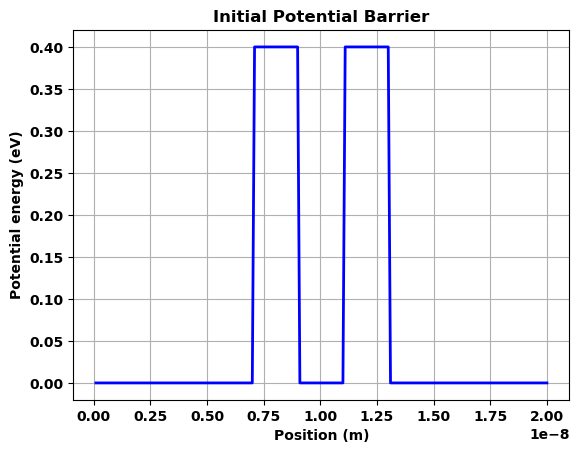

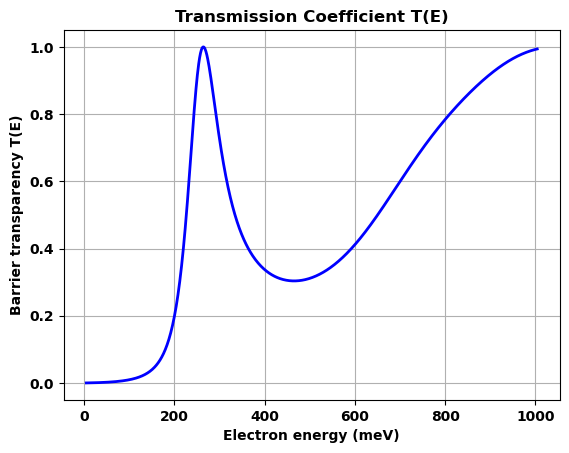

In [3]:
# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------

plt.figure(1)
plt.plot(x, potV / qe, 'b', linewidth=2)
plt.xlabel('Position (m)')
plt.ylabel('Potential energy (eV)')
plt.title('Initial Potential Barrier')
plt.grid(True)

plt.figure(2)
plt.plot(Ene * 1000, Trans, 'b', linewidth=2)
plt.xlabel('Electron energy (meV)')
plt.ylabel('Barrier transparency T(E)')
plt.title('Transmission Coefficient T(E)')
plt.grid(True)